In [1]:
import pandas as pd
import numpy as np
from sargas import *
import matplotlib.pyplot as plt
from multiprocessing import Pool
%matplotlib inline

# $\mu$VT

In [3]:
# Helper functions to build and run simulations

def build_muvt(mu, v, t, maximum_nparticles, rc, tail_correction):
    potential = Potential.lennard_jones(1.0, 1.0, rc, tail_correction=True)
    configuration = Configuration.from_lattice(maximum_nparticles, maximum_nparticles / v)
    system = System(configuration, potential)
    displace_particle = MCMove.displace_particle(0.1, 0.4, t)
    insert_delete_particle = MCMove.insert_delete_particle(mu, t)
    
    mc = MonteCarlo([displace_particle, insert_delete_particle], [0.7, 0.3], t)
    simulation = Simulation.monte_carlo(system, mc, n)
    return simulation, system

def run_tp(t, p):
    nparticles = 500
    initial_density = 8e-1
    rc = 3.0
    tail_correction = True
    sim, sys = build_npt(500, p, t, initial_density, rc, True)
    properties = run_simulation(sim, 500*5000, 500*50000)
    return t, p, properties

def build_nvt(n, rho, t, rc, tail_correction):
    potential = Potential.lennard_jones(1.0, 1.0, rc, tail_correction=True)
    configuration = Configuration.from_lattice(n, rho)
    system = System(configuration, potential)
    displace_particle = MCMove.displace_particle(0.1, 0.4, t)
    mc = MonteCarlo([displace_particle], [1], t)
    simulation = Simulation.monte_carlo(system, mc, n)
    return simulation, system

def run_simulation(simulation, equilibration, production):
    simulation.run(equilibration)
    simulation.deactivate_propagator_updates()
    
    properties = Observer.properties(1000)
    simulation.add_observer(properties)
    
    widom = Observer.widom_insertion(100)
    simulation.add_observer(widom)
    
    simulation.run(production)
    return pd.DataFrame(properties.data), widom

In [4]:
nparticles = 500
density = 8e-1
volume = nparticles / density
rc = 3.0
tail_correction = True

In [5]:
%%time
t1 = 8e-1
sim1, sys1 = build_nvt(500, 8e-1, t1, rc, True)
props1, widom1 = run_simulation(sim1, 500*5000, 500*50000)

CPU times: user 7min 50s, sys: 552 ms, total: 7min 50s
Wall time: 10min 4s


In [8]:
mu = pd.DataFrame(widom1.data)

In [9]:
from scipy.special import logsumexp

In [18]:
(logsumexp(-mu/t1) - np.log(len(mu))) / t1

5.157882408943588

In [15]:
np.log(8e-1 * np.mean(np.exp(-mu/t1))) / t1

mu    4.878953
dtype: float64

In [78]:
%%time
states = [
    (8e-1, 8e-1),
    (8.5e-1, 8e-1)
]

with Pool() as pool:
    res = pool.starmap(run_tp, states)

CPU times: user 8.99 ms, sys: 96 ms, total: 105 ms
Wall time: 5min 47s


In [49]:
t1 = 9e-1
p1 = 8e-1
props1 = res[0]

t2 = 9e-1
p2 = 1.2
props2 = res[1]

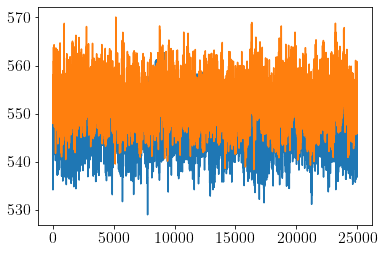

In [79]:
plt.plot(res[0][2].volume)
plt.plot(res[1][2].volume)

# Physical Validation

In [50]:
import physical_validation as pv

In [80]:
units = pv.data.UnitData(
    kb=1.0,
    energy_str='eps',
    energy_conversion=1.0,
    length_str='sigma',
    length_conversion=1.0,
    volume_str='sigma3',
    volume_conversion=1.0,
    temperature_str='T*',
    temperature_conversion=1.0,
    pressure_str='p*',
    pressure_conversion=1.0,
    time_str='t*',
    time_conversion=1.0
)

def simulation_data(t, p, data):
    nparticles = data.nparticles.values[0]
    sd = pv.data.SimulationData()
    sd.system = pv.data.SystemData(natoms=nparticles)
    sd.units = units
    sd.ensemble = pv.data.EnsembleData(
        ensemble="NPT",
        natoms=nparticles,
        pressure=p,
        temperature=t
    )
    sd.observables = pv.data.ObservableData(
        potential_energy=data.energy,
        volume=data.volume
    )
    return sd

In [81]:
sd = list(map(lambda x: simulation_data(*x), res))

After equilibration, decorrelation and tail pruning, 0.72% (179 frames) of original Trajectory 1 remain.
After equilibration, decorrelation and tail pruning, 1.24% (310 frames) of original Trajectory 2 remain.
Overlap is 55.9% of trajectory 1 and 51.6% of trajectory 2.
Rule of thumb estimates that dT = 0.1 would be optimal (currently, dT = 0.0)
Maximum Likelihood Analysis (analytical error)
Free energy
    229.43313 +/- 33.51373
Estimated slope                  |  True slope
    0.073073  +/- 0.010690       |  0.073529 
    (0.04 quantiles from true slope)
Estimated dT                     |  True dT
    0.0    +/- 0.0               |  0.0   


/usr/ITT/bauer/PhD/Code/sargas/sargas_venv/lib/python3.8/site-packages/physical_validation/util/plot.py:147: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


[0.042709160277769824]

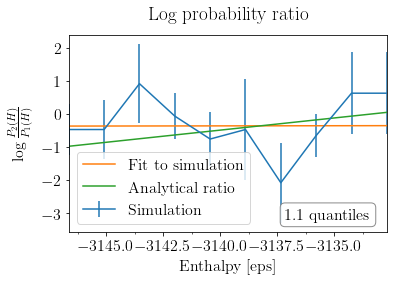

In [82]:
pv.ensemble.check(
    data_sim_one=sd[0],
    data_sim_two=sd[1],
    screen=True
)